# Post-processing the PTOF Data_mass_M..dat

In this notebook, we process and visualise the outputed numerical results containing the total mass of solute in the domain (before breakthrough)

## 0. Simulation summary
**Structure dimensions: geometry G13**  
- domain length: $L=11.4$ cm
- domain width : $W=7.3$ cm
- grain diameter: $d=0.92$ mm

**OpenFoam**  
The steady-state flow field is calculated using the modified _simpleHeleShaw_ solver in OpenFoam.  
**PTOF**  
The mean steady-state flow velocity is integrated while running the PTOF code (170225 version): 
- n13sat: $\overline{u}=9.88\times10^{-6}$ m/s
- n13   : $\overline{u}=9.73\times10^{-6}$ m/s
  
The advective time unit then can be calculated as:  
- n13sat: $\tau_a=\frac{d}{\overline{u}}=\frac{0.92\times10^{-3} m}{9.88\times10^{-6} m/s}=93.1 m/s$
- n13: $\tau_a=\frac{\overline{u}}{d}=\frac{0.92\times10^{-3} m}{9.73\times10^{-6} m/s}=94.5 m/s$

In [1]:
# calculate the advective time unit
d=0.92e-3               # mean grain diameter, m
u_n13sat=9.88e-6        # mean velocity, m/s  
u_n13=9.73e-6          
td_n13sat=d/u_n13sat    # advective time unit, s
td_n13=d/u_n13
print(td_n13sat, td_n13)

93.11740890688259 94.55292908530319


In [2]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D                # create seperate legend 
import sys
import os

sys.path.append(os.path.abspath("../modules"))     # modify sys.path in the notebook or script
from preprocess import *                           # import preprocess module

## 1. Solid surface decay with varied _Pe_ and _Da_ numbers



### 1.1. Video
We first to generate videos of reactive transport simulations under satu- and unsatu- conditions.  
we will need to write functions to generate videos in the case of interest and a function to show them here

In [3]:
# use fucntions to display videos and images

### 1.2. Read output Mass...dat files
Here, we read and process the output _Data_mass_M.....dat_ data from solid Surface Decay simulations, including:  
- saturated: n13sat  
- unsaturated: n13

In [4]:
simu="/mnt/disk2/OPTOD_040725"       # simulation folder

############################ Read n13sat Saturated output ############################################################
Peclet_n13sat=["1e1","5e1","1e2","5e2","1e3","5e3"]             # list of Peclet
Damkho_n13sat=["0","1e-2","5e-2","1e-1","5e-1","1e0","5e0"]             # list of Damkholer

# since the axes of index (Pe,Da) are strings, 
# we use the nested (嵌套的) dictionary to sturcture the data
time_full_n13sat={}                                 
mass_full_n13sat={}                                 
time_BT_n13sat={}                               
mass_BT_n13sat={}                                 
for Pe in Peclet_n13sat:                                # loop Pe
    time_full_n13sat[Pe]={}                             # fill the key with Pe
    mass_full_n13sat[Pe]={}
    time_BT_n13sat[Pe]={}
    mass_BT_n13sat[Pe]={}
    for Da in Damkho_n13sat:                            # loop Da
        case=simu+"/n13sat"+"/1_Surface_decay_2d/Particle1e5/"+"Pe"+Pe+"/n13sat_Da_"+Da+"/output"   # case path
        bt=breakthrough_time(case)                      # get case breakthrough time
        #print(f"{case} : BT time t={bt} \n")
        
        keyword="Data_mass_M"
        case_Mass_path=detect_file_path(case,keyword)
        t_full, m_full, t_BT, m_BT=read_Mass_file(case_Mass_path,bt)
        
        time_full_n13sat[Pe][Da]=t_full
        mass_full_n13sat[Pe][Da]=m_full
        time_BT_n13sat[Pe][Da]=t_BT
        mass_BT_n13sat[Pe][Da]=m_BT

############################ Read n13 Unsaturated output ############################################################
Peclet_n13=["1e1","5e1","1e2","5e2","1e3","5e3"]             # list of Peclet
Damkho_n13=["0","1e-2","5e-2","1e-1","5e-1","1e0","5e0"]             # list of Damkholer

# since the axes of index (Pe,Da) are strings, 
# we use the nested (嵌套的) dictionary to sturcture the data
time_full_n13={}                                 
mass_full_n13={}                                 
time_BT_n13={}                               
mass_BT_n13={}                                 
for Pe in Peclet_n13:                                # loop Pe
    time_full_n13[Pe]={}                             #fill the key with Pe
    mass_full_n13[Pe]={}
    time_BT_n13[Pe]={}
    mass_BT_n13[Pe]={}
    for Da in Damkho_n13:                            # loop Da
        case=simu+"/n13"+"/1_Surface_decay_2d/Particle1e5/"+"Pe"+Pe+"/n13_Da_"+Da+"/output"   # case path
        bt=breakthrough_time(case)                   # get case breakthrough time
        #print(f"{case} : BT time t={bt} \n")
        
        keyword="Data_mass_M"
        case_Mass_path=detect_file_path(case,keyword)
        t_full, m_full, t_BT, m_BT=read_Mass_file(case_Mass_path,bt)
        
        time_full_n13[Pe][Da]=t_full
        mass_full_n13[Pe][Da]=m_full
        time_BT_n13[Pe][Da]=t_BT
        mass_BT_n13[Pe][Da]=m_BT

### 1.3. Plot data at different _Pe_ (varied _Da_)
Plot the solid surface decay results based on the of _Mass....dat_ output file at different _Pe_. The time is scaled using advective time _$t_d$_. There could three types of figures  
**Left**: Mass vs. time: time evolution of remainning mass in the porous media domain before breakthrough.  
Steeper decay in mass implies faster reaction or stronger dispersion.  
**Middle**: Reaction rate vs. time: negative slope of mass curve, indicating the speed of mass consumption. Peaks represent the most intense reaction activity. 
\begin{equation}
k(t)=\frac{1}{M_0}\frac{dM}{dt}
\end{equation}  
the unit of of _k_ is inverse of time. Sine $M_0=1$, k = np.gradient(M, t).  
**Right**: Reaction efficiency vs. time: a fraction (or percentage) of mass that has reacted by time.  
\begin{equation}
\eta(t)=\frac{M_0-M(t)}{M_0}
\end{equation}  
It gives time-dependent measure of how effective the system is at reacting the solute  
- if $\eta=0\rightarrow$ no reaction occurs
- if $\eta=0.5\rightarrow$ half the mass has reacted
- if $\eta=1\rightarrow$ all the reactive mass has reacted

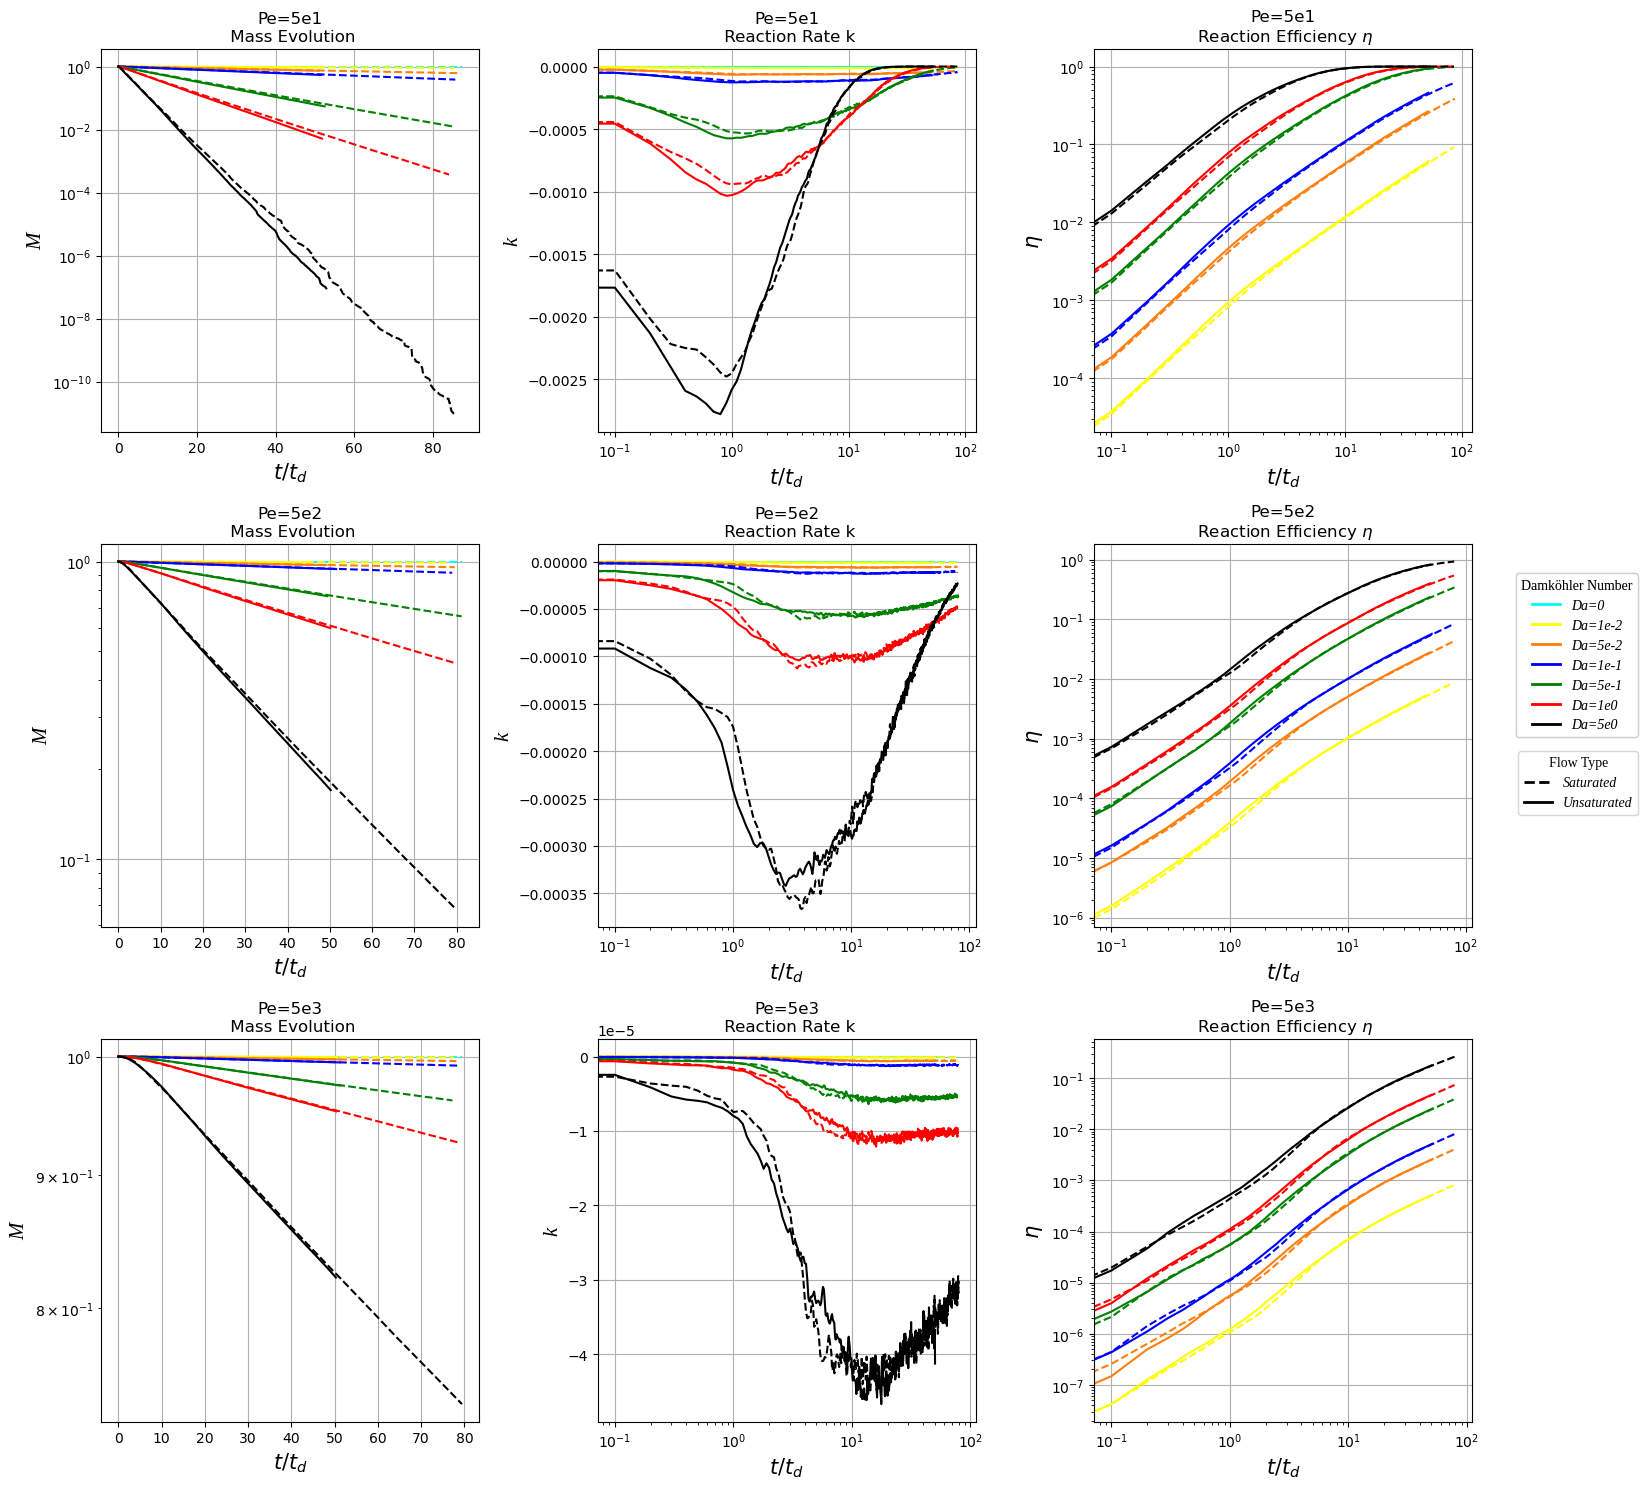

In [5]:
Pe_draw1=["5e1","5e2","5e3"]             
Da_draw1=["0","1e-2","5e-2","1e-1","5e-1","1e0","5e0"]
colors1=["cyan","yellow","tab:orange","blue","green","red","black"]

figure,axes=plt.subplots(len(Pe_draw1),3,figsize=(15,15),facecolor='white', sharex=False, sharey=False)    # config figure and axes at the same time

for i, Pe in enumerate(Pe_draw1):
    for j, Da in enumerate(Da_draw1):
        # satu data
        t_BT_n13sat=time_BT_n13sat[Pe][Da] 
        m_BT_n13sat=mass_BT_n13sat[Pe][Da]
        k_BT_n13sat=np.gradient(m_BT_n13sat, t_BT_n13sat)                 # compute dM/dt using numpy gradient
        eta_BT_n13sat=(m_BT_n13sat[0] - m_BT_n13sat) / m_BT_n13sat[0]           # reaction efficiency η(t)   
        
        # unsatu data
        t_BT_n13=time_BT_n13[Pe][Da]       
        m_BT_n13=mass_BT_n13[Pe][Da]
        k_BT_n13=np.gradient(m_BT_n13, t_BT_n13)                          # compute dM/dt using numpy gradient
        eta_BT_n13=(m_BT_n13[0] - m_BT_n13) / m_BT_n13[0]                       # reaction efficiency η(t)   

        # Plot 3 things in row i:
        axes[i, 0].plot(t_BT_n13/td_n13, m_BT_n13, label=f"Da={Da}", color=colors1[j])
        axes[i, 1].plot(t_BT_n13/td_n13, k_BT_n13, label=f"Da={Da}", color=colors1[j])
        axes[i, 2].plot(t_BT_n13/td_n13, eta_BT_n13, label=f"Da={Da}", color=colors1[j])     

        axes[i, 0].plot(t_BT_n13sat/td_n13sat, m_BT_n13sat, label=f"Da={Da}", color=colors1[j], linestyle='--')
        axes[i, 1].plot(t_BT_n13sat/td_n13sat, k_BT_n13sat, label=f"Da={Da}", color=colors1[j], linestyle='--')
        axes[i, 2].plot(t_BT_n13sat/td_n13sat, eta_BT_n13sat, label=f"Da={Da}", color=colors1[j], linestyle='--')  
#########################################################################################
############################### Set figure configuration ################################
#########################################################################################
#===== Set global font to 'Liberation Serif'======#
rc = {"font.family": "serif", "mathtext.fontset": "cm"}
plt.rcParams.update(rc)
plt.rcParams['font.family'] = ['serif']
plt.rcParams["font.serif"] = ["Liberation Serif"]
# Set specific font properties for labels and legends
font_label = {'family': 'Liberation Serif', 'size': 15, 'style': 'italic'}
font_legend = {'family': 'Liberation Serif', 'size': 10, 'style': 'italic'}

#============== Common config for all============#
# flatten the 2D multiple figure index array into 1D, then loop over each 
# This is useful when set the same parameter for each subplot
# Add legends and labels
for ax in axes.flatten():          
    ax.set_xlabel(r"$t/t_d$",fontdict=font_label)
    #ax.set_xlim(0,8000)
    #ax.set_xscale('log')           # ← log-scale x-axis
    #ax.set_yscale('log')           # ← log-scale y-axis
    #ax.legend(loc='lower left',markerscale=1,prop=font_legend,frameon=True)
    ax.grid(True)

#============== Raw config for different type figure ============#
for i, Pe in enumerate(Pe_draw1):    # loop each Pe
    #----------------- Column log -------------#
    #axes[i,0].set_xscale('log')   # M log
    axes[i,0].set_yscale('log')    
    axes[i,1].set_xscale('log')    # k log
    #axes[i,1].set_yscale('log')     
    axes[i,2].set_xscale('log')    # eta log
    axes[i,2].set_yscale('log') 
#----------------- Column lim -------------#
    #axes[i,0].set_ylim(1e-10,2e0)   # M y-axis lim
    #axes[i,1].set_ylim(-0.002,0.0001)   # k y-axis lim 
    #axes[i,2].set_ylim(1e-7,2e0)   # eta y-axis lim 
#============== Column config for different Peclet figure ============#
column_labels = [r'M', r'k', r'$\eta$']
column_titles = [r"Mass Evolution", r"Reaction Rate k", r"Reaction Efficiency $\eta$"]
for j in range(3):                                  # Loop over columns
    for i, Pe in enumerate(Pe_draw1):                   # Loop over rows
        axes[i,j].set_ylabel(column_labels[j],fontdict=font_label)    #set yaxis_label
        axes[i,j].set_title(f"Pe={Pe}\n {column_titles[j]}")  # set titles
#============== Legend ============#
flow_types = ['Saturated', 'Unsaturated']
linestyles = ['--', '-']
# create a legend for Da curves
legend_Da =[Line2D([0], [0], color=colors1[i], lw=2, label=f"Da={Da_draw1[i]}") for i in range(len(Da_draw1))]
legend1 = figure.legend(handles=legend_Da, title="Damköhler Number", loc='lower right',bbox_to_anchor=(1.1,0.5),prop=font_legend,frameon=True)
# create a legend for line style
legend_flow=[Line2D([0], [0], color='black', lw=2, linestyle=linestyles[i], label=flow_types[i]) for i in range(len(flow_types))]
legend2 = figure.legend(handles=legend_flow, title="Flow Type", loc='upper right',bbox_to_anchor=(1.1,0.5),prop=font_legend,frameon=True)
figure.add_artist(legend1)  # Add the first legend back after the second one (so it doesn't get overwritten)

#============== Save figure ============#
plt.tight_layout()   # automatically adjusts the spacing between subplots
#plt.savefig('Mass.png', dpi=500, bbox_inches='tight', format='png')
#plt.savefig('Draw_caviy_depth.pdf', dpi=500, bbox_inches='tight', format='pdf')
plt.show()

### 1.4 Plot data at different _Da_ (varied _Pe_)
Plot the solid surface decay results based on the of _Mass....dat_ output file at different _Da_. The time is scaled using advective time _$t_d$_. There could three types of figures  
**Left**: Mass vs. time: time evolution of remainning mass in the porous media domain before breakthrough.  
Steeper decay in mass implies faster reaction or stronger dispersion.  
**Middle**: Reaction rate vs. time: negative slope of mass curve, indicating the speed of mass consumption. Peaks represent the most intense reaction activity. 
\begin{equation}
k(t)=\frac{1}{M_0}\frac{dM}{dt}
\end{equation}  
the unit of of _k_ is inverse of time. Sine $M_0=1$, k = np.gradient(M, t).  
**Right**: Reaction efficiency vs. time: a fraction (or percentage) of mass that has reacted by time.  
\begin{equation}
\eta(t)=\frac{M_0-M(t)}{M_0}
\end{equation}  
It gives time-dependent measure of how effective the system is at reacting the solute  
- if $\eta=0\rightarrow$ no reaction occurs
- if $\eta=0.5\rightarrow$ half the mass has reacted
- if $\eta=1\rightarrow$ all the reactive mass has reacted

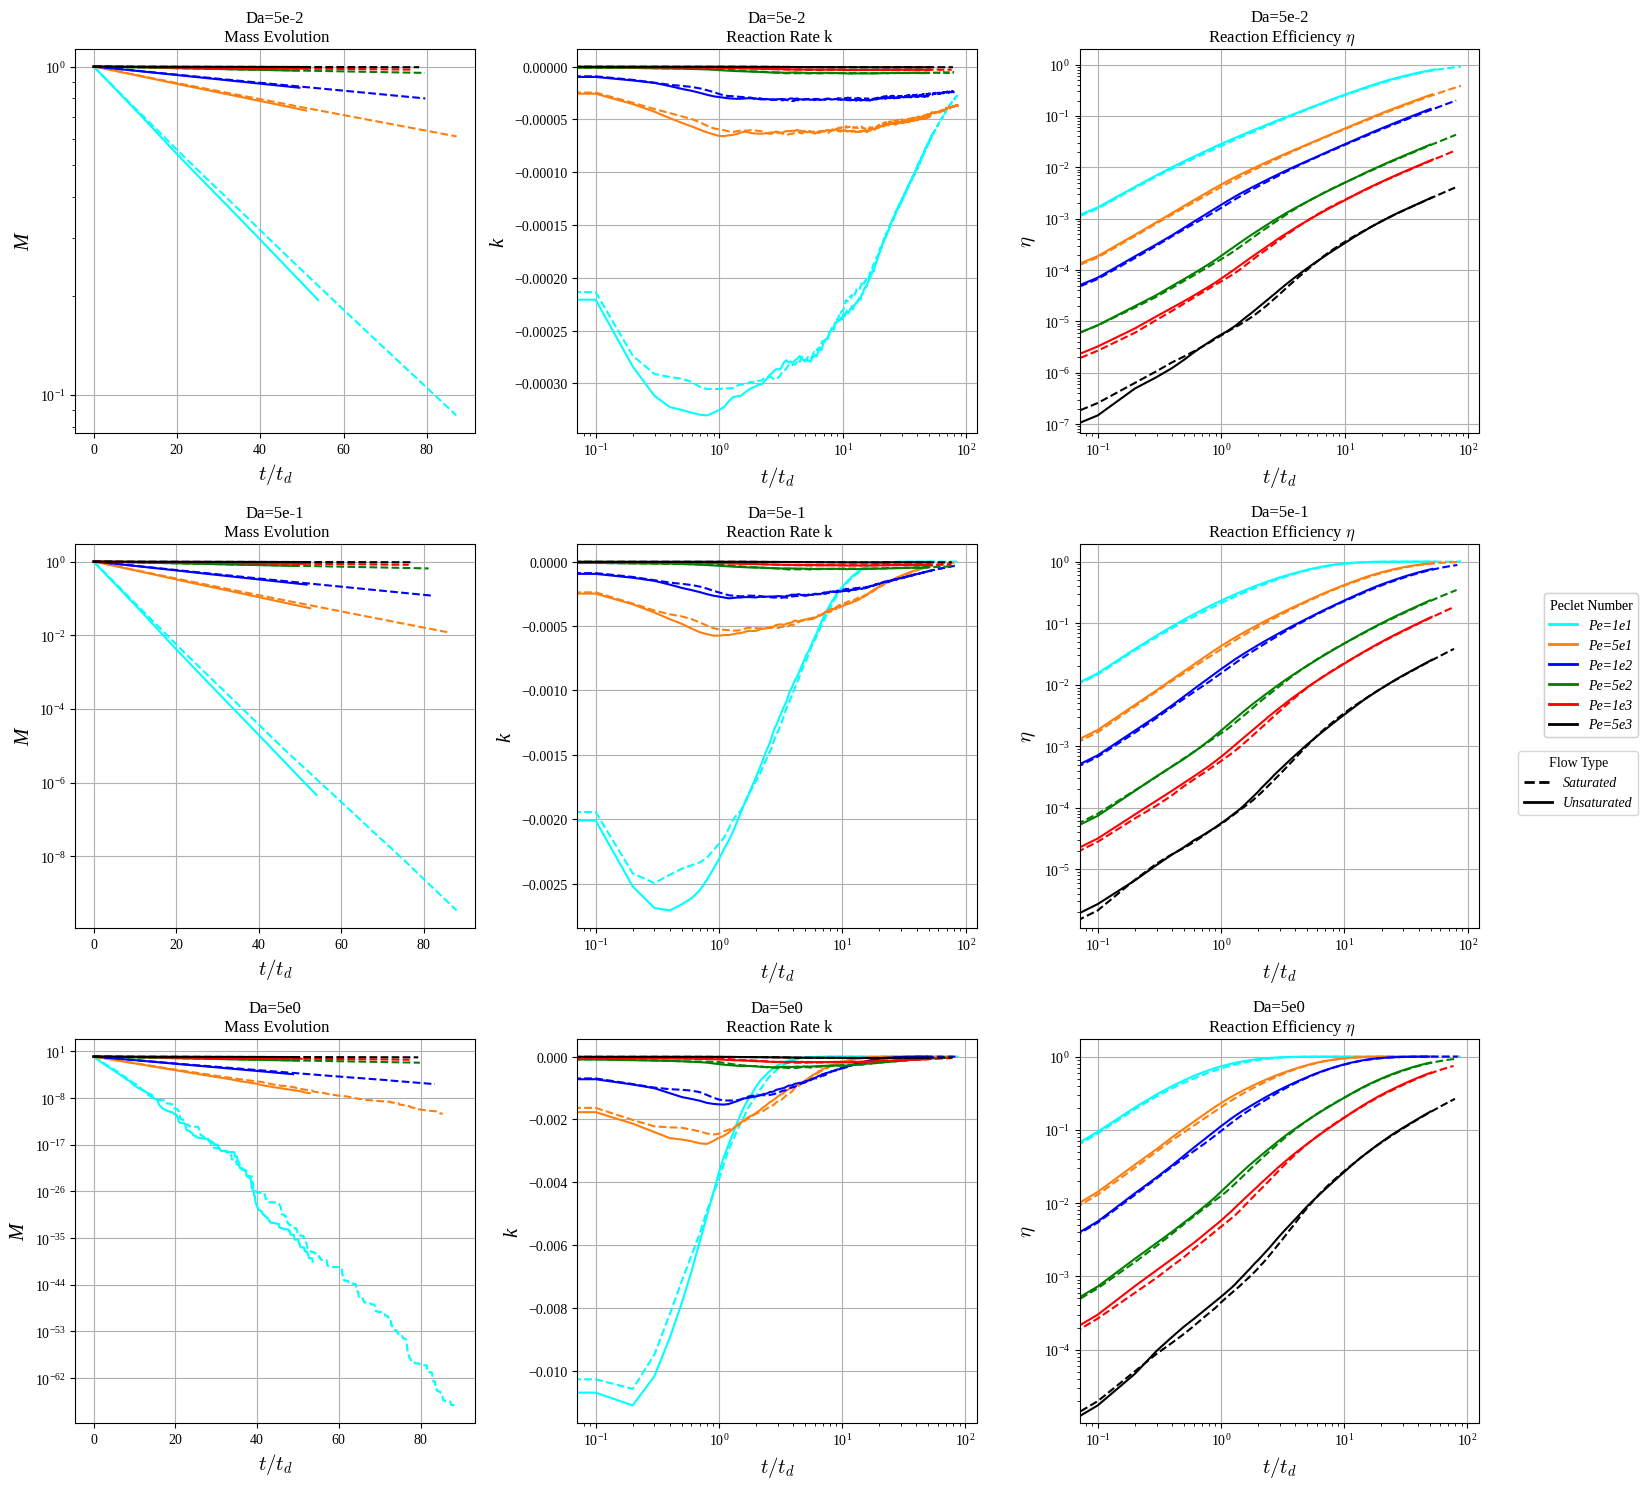

In [10]:
Pe_draw2=["1e1","5e1","1e2","5e2","1e3","5e3"]             
Da_draw2=["5e-2","5e-1","5e0"]
colors2=["cyan","tab:orange","blue","green","red","black"]

figure,axes=plt.subplots(len(Da_draw2),3,figsize=(15,15),facecolor='white', sharex=False, sharey=False)    # config figure and axes at the same time

for j, Da in enumerate(Da_draw2):
    for i, Pe in enumerate(Pe_draw2):
        # satu data
        t_BT_n13sat=time_BT_n13sat[Pe][Da] 
        m_BT_n13sat=mass_BT_n13sat[Pe][Da]
        k_BT_n13sat=np.gradient(m_BT_n13sat, t_BT_n13sat)                 # compute dM/dt using numpy gradient
        eta_BT_n13sat=(m_BT_n13sat[0] - m_BT_n13sat) / m_BT_n13sat[0]           # reaction efficiency η(t)   
        
        # unsatu data
        t_BT_n13=time_BT_n13[Pe][Da]       
        m_BT_n13=mass_BT_n13[Pe][Da]
        k_BT_n13=np.gradient(m_BT_n13, t_BT_n13)                          # compute dM/dt using numpy gradient
        eta_BT_n13=(m_BT_n13[0] - m_BT_n13) / m_BT_n13[0]                       # reaction efficiency η(t)   

        # Plot 3 things in row j:
        axes[j, 0].plot(t_BT_n13/td_n13, m_BT_n13, label=f"Pe={Pe}", color=colors2[i])
        axes[j, 1].plot(t_BT_n13/td_n13, k_BT_n13, label=f"Pe={Pe}", color=colors2[i])
        axes[j, 2].plot(t_BT_n13/td_n13, eta_BT_n13, label=f"Pe={Pe}", color=colors2[i])     

        axes[j, 0].plot(t_BT_n13sat/td_n13sat, m_BT_n13sat, label=f"Pe={Pe}", color=colors2[i], linestyle='--')
        axes[j, 1].plot(t_BT_n13sat/td_n13sat, k_BT_n13sat, label=f"Pe={Pe}", color=colors2[i], linestyle='--')
        axes[j, 2].plot(t_BT_n13sat/td_n13sat, eta_BT_n13sat, label=f"Pe={Pe}", color=colors2[i], linestyle='--')  
#########################################################################################
############################### Set figure configuration ################################
#########################################################################################
#===== Set global font to 'Liberation Serif'======#
rc = {"font.family": "serif", "mathtext.fontset": "cm"}
plt.rcParams.update(rc)
plt.rcParams['font.family'] = ['serif']
plt.rcParams["font.serif"] = ["Liberation Serif"]
# Set specific font properties for labels and legends
font_label = {'family': 'Liberation Serif', 'size': 15, 'style': 'italic'}
font_legend = {'family': 'Liberation Serif', 'size': 10, 'style': 'italic'}

#============== Common config for all============#
# flatten the 2D multiple figure index array into 1D, then loop over each 
# This is useful when set the same parameter for each subplot
# Add legends and labels
for ax in axes.flatten():          
    ax.set_xlabel(r"$t/t_d$",fontdict=font_label)
    #ax.set_xlim(0,8000)
    #ax.set_xscale('log')           # ← log-scale x-axis
    #ax.set_yscale('log')           # ← log-scale y-axis
    #ax.legend(loc='lower left',markerscale=1,prop=font_legend,frameon=True)
    ax.grid(True)

#============== Raw config for different type figure ============#
for j, Da in enumerate(Da_draw2):    # loop each Da
    #----------------- Column log -------------#
    #axes[j,0].set_xscale('log')   # M log
    axes[j,0].set_yscale('log')    
    axes[j,1].set_xscale('log')    # k log
    #axes[j,1].set_yscale('log')     
    axes[j,2].set_xscale('log')    # eta log
    axes[j,2].set_yscale('log') 
#----------------- Column lim -------------#
    #axes[j,0].set_ylim(1e-5,2e0)   # M y-axis lim
    #axes[j,1].set_ylim(-0.0016,0.0001)   # k y-axis lim 
    #axes[j,2].set_ylim(1e-7,2e0)   # eta y-axis lim 
#============== Column config for different Peclet figure ============#
column_labels = [r'M', r'k', r'$\eta$']
column_titles = [r"Mass Evolution", r"Reaction Rate k", r"Reaction Efficiency $\eta$"]
for j in range(3):                                  # Loop over columns
    for i, Da in enumerate(Da_draw2):                   # Loop over rows
        axes[i,j].set_ylabel(column_labels[j],fontdict=font_label)    #set yaxis_label
        axes[i,j].set_title(f"Da={Da}\n {column_titles[j]}")  # set titles
#============== Legend ============#
flow_types = ['Saturated', 'Unsaturated']
linestyles = ['--', '-']
# create a legend for Pe curves
legend_Pe =[Line2D([0], [0], color=colors2[i], lw=2, label=f"Pe={Pe_draw2[i]}") for i in range(len(Pe_draw2))]
legend1 = figure.legend(handles=legend_Pe, title="Peclet Number", loc='lower right',bbox_to_anchor=(1.1,0.5),prop=font_legend,frameon=True)
# create a legend for line style
legend_flow=[Line2D([0], [0], color='black', lw=2, linestyle=linestyles[i], label=flow_types[i]) for i in range(len(flow_types))]
legend2 = figure.legend(handles=legend_flow, title="Flow Type", loc='upper right',bbox_to_anchor=(1.1,0.5),prop=font_legend,frameon=True)
figure.add_artist(legend1)  # Add the first legend back after the second one (so it doesn't get overwritten)

#============== Save figure ============#
plt.tight_layout()   # automatically adjusts the spacing between subplots
#plt.savefig('Mass.png', dpi=500, bbox_inches='tight', format='png')
#plt.savefig('Draw_caviy_depth.pdf', dpi=500, bbox_inches='tight', format='pdf')
plt.show()

## 2. Gas surface decay

We simply apply the **reacting** boundary condition to the bubble surface.

In [7]:
#******** Plot data*************#
plt.plot(Soli_Pe1e2_Da1e0_Time, Soli_Pe1e2_Da1e0_Mass, color='red', linestyle='-')
plt.plot(Soli_Pe1e2_Da1e0_Time, Soli_Pe1e2_Da1e0_Mass, color='red', linestyle='-')

#******************* Set font and legend ***********************************************#
# Set global font to 'Liberation Serif'
rc = {"font.family": "serif", "mathtext.fontset": "cm"}
plt.rcParams.update(rc)
plt.rcParams['font.family'] = ['serif']
plt.rcParams["font.serif"] = ["Liberation Serif"]
# Set specific font properties for labels and legends
font_label = {'family': 'Liberation Serif', 'size': 15, 'style': 'italic'}
font_legend = {'family': 'Liberation Serif', 'size': 10, 'style': 'italic'}

plt.xlabel(r'$t$', font_label)
plt.ylabel(r'$M$', font_label)
plt.xlim(0,5000)
#plt.ylim(0,1.01)
#plt.xscale('log')
#plt.yscale('log')
#plt.grid(axis='y',linestyle=':')
#plt.gca().set_aspect(1)
#plt.legend(['old_code','new_code'],loc='lower left',markerscale=1,prop=font_legend,frameon=True)
plt.savefig('Mass.png', dpi=500, bbox_inches='tight', format='png')
#plt.savefig('Draw_caviy_depth.pdf', dpi=500, bbox_inches='tight', format='pdf')
#plt.show()

NameError: name 'Soli_Pe1e2_Da1e0_Time' is not defined